<a href="https://colab.research.google.com/github/renjmindy/AutomaticImageCaptionGenerator/blob/master/capstone_project_image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download stuff

In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

TensorFlow 1.x selected.
--2020-09-22 02:53:33--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-09-22 02:53:34 (50.8 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
**************************************************
val2014_sample.zip
******

# Import stuff

In [ ]:
import sys
sys.path.append("..")
import download_utils
download_utils.link_all_keras_resources()
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Prepare the storage for model checkpoints

Leave USE_GOOGLE_DRIVE = False, if you're running locally! 

Set USE_GOOGLE_DRIVE = True in Google Colab is recommended! 

If set to True, Google Drive will be mounted, so that the checkpoint can be restored anytime and continue trainig even if the previous Colab session dies. 

If set to True, follow on-screen instructions to access Google Drive (one Google account is a must-have).

In [ ]:
USE_GOOGLE_DRIVE = False

In [ ]:
def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

In [ ]:
CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

In [ ]:
def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))

**example of checkpoint dir**

In [ ]:
print(get_checkpoint_path(10))

/content/weights_10


# Download data

The dowloading of all necessary image files takes 10 hours, and the overall size of all images is around 20 GB. 

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

Image data has been downloaded and stored in somewhere. It can be retrieved by running dowload_utils.py

In [ ]:
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding.

In [ ]:
IMG_SIZE = 299

The last hidden layer of pretrained InceptionV3 model is called in order to behave as an image embedding. 

In [ ]:
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

(1) **load pretrained model**
```python
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()
```

(2) **extract train features**
```python
train_img_embeds, train_img_fns = utils.apply_model("train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")
```

(3) **extract validation features**
```python
val_img_embeds, val_img_fns = utils.apply_model("val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")
```

(4) **sample images for learners**
```python
    def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
      np.random.seed(seed)
      with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
          fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [ ]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [ ]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

**extract captions from zip**

In [ ]:
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))

In [ ]:
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", "annotations/captions_train2014.json")
val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


**look at training example (each has 5 captions)**

You can change example_idx and see different images



In [ ]:
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()

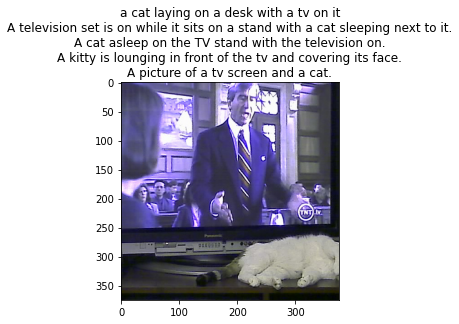

In [ ]:
show_trainig_example(train_img_fns, train_captions, example_idx=22)

# Prepare captions for training

**preview caption data**

In [ ]:
train_captions[20:22]

[['a person walking with a cow near other people ',
  'A man leads a cow into a market.',
  'The cow is standing still as a man holds her lead.',
  'A cow being lead around on a showroom floor.',
  'A man is holding a cow on a leash'],
 ['a woman rides on a skate board through a skate park',
  'a girl riding a skateboard in a skate park',
  'A young girl skateboarding at a skate park while other watch.',
  'a young girl skateboarding across a ramp at a skate park',
  'A girls skateboarding at a skateboard park while lots of people watch her']]

**special tokens**

In [ ]:
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

**split one single sentence into tokens (split into lowercased letters)**

In [ ]:
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

Return {token: index} for all train tokens (words) that occur 5 times or more. `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary. Use `split_sentence` function to split sentence into tokens. Also, add **PAD** (for batch padding), **UNK** (unknown, out of vocabulary), **START** (start of sentence) and **END** (end of sentence) tokens into the vocabulary.

In [ ]:
def generate_vocabulary(train_captions):
      
    tokens_list = list(token for caption in train_captions for sentence in caption for token in split_sentence(sentence))
    tokens_dict = {}
    for token in tokens_list:
      tokens_dict[token] = tokens_dict.get(token, 0) + 1

    vocab_list = []
    for k,v in tokens_dict.items():
      if v >= 5:
        vocab_list.append(k)

    added_tokens = [PAD, UNK, START, END]
    vocab_list.extend(added_tokens)

    vocab = {token: index for index, token in enumerate(sorted(vocab_list))}
    
    return vocab

**prepare vocabulary**

In [ ]:
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769



 `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]

Use `split_sentence` function to split sentence into tokens. Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary). Add START and END tokens to start and end of each sentence respectively.
    
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]

In [ ]:
def caption_tokens_to_indices(captions, vocab):
  
  res = list(list([vocab[START]] + list(vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)) \
                  + [vocab[END]] for sentence in caption) for caption in captions)

  return res

**replace tokens with indices**

In [ ]:
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

 `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    
Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns), where "columns" is max(map(len,batch_captions)) when max_len is None and "columns" = min(max_len, max(map(len, batch_captions))) otherwise. Add padding with pad_idx where necessary.

    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!

In [ ]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
  
    columns = max(map(len,batch_captions)) if max_len == None else min(max_len, max(map(len,batch_captions)))
    matrix = list(list(index for i, index in enumerate(caption[:columns])) + [pad_idx] * (max(columns-len(caption), 0)) \
                  for caption in batch_captions)

    return np.array(matrix)

**make sure you use correct argument in caption_tokens_to_indices**

In [ ]:
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/).

In [ ]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

**remember to reset your graph if you want to start building it from scratch!**

In [ ]:
s = reset_tf_session()
tf.set_random_seed(42)

Here, one decoder is defined.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:

```python
dense_layer = L.Dense(42, input_shape=(None, 100), activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

In [ ]:
class decoder:
    
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # **************************************************************************

    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, input_shape=(None, IMG_EMBED_SIZE), activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS, input_shape=(None, IMG_EMBED_BOTTLENECK), activation='elu')
    # initial lstm cell state of shape (None, LSTM_UNITS)
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # **************************************************************************

    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, input_shape=(None, LSTM_UNITS), activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab), input_shape=(None, LOGIT_BOTTLENECK))
    # embed all tokens
    word_embeds = word_embed(sentences[:, :-1])

    # **************************************************************************
    
    # get all the hidden states by using ground truth tokens `word_embeds` as context for next token prediction
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds, initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))
    # reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])
    # calculate token logits for all the hidden states
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    # flatten the ground truth token ids
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1,])
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)
    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=flat_ground_truth, logits=flat_token_logits)
    # compute average `xent` over tokens with nonzero `flat_loss_mask`
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**define optimizer operation to minimize the loss**

In [ ]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

**save/load network weights**

In [ ]:
saver = tf.train.Saver()

**intialize all variables**

In [ ]:
s.run(tf.global_variables_initializer())

## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [ ]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

`images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE]. `indexed_captions` holds 5 vocabulary indexed captions for each image:
   
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]

Generate a random batch of size `batch_size`. Take random images and choose one random caption for each image. Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter. Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.

**generate batch via random sampling of images and captions for them**

In [ ]:
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    
    batch = np.random.choice(len(images_embeddings), batch_size, replace=False)
    batch_image_embeddings = images_embeddings[batch]

    batch_captions = list(caption[np.random.randint(5)] for caption in indexed_captions[batch])
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, decoder.sentences: batch_captions_matrix}

In [ ]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  

Look at the training and validation loss, they should be decreasing!

In [ ]:
# actual training loop
MAX_LEN = 20  

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds, val_captions_indexed, batch_size, MAX_LEN))
        
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.284798
Epoch: 0, train loss: 4.284798083782196, val loss: 3.7089175176620484
**************************************************
Training loss: 3.367287
Epoch: 1, train loss: 3.367287338256836, val loss: 3.1387262749671936
**************************************************
Training loss: 3.024860
Epoch: 2, train loss: 3.0248595180511475, val loss: 2.964656448364258
**************************************************
Training loss: 2.859977
Epoch: 3, train loss: 2.8599770221710203, val loss: 2.864643545150757
**************************************************
Training loss: 2.768457
Epoch: 4, train loss: 2.7684573912620545, val loss: 2.8034080171585085
**************************************************
Training loss: 2.705025
Epoch: 5, train loss: 2.705024628639221, val loss: 2.7335978293418886
Instructions for updating:
Use standard file APIs to delete files with this prefix.
*********************************************

In [ ]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

In [ ]:
def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

In [ ]:
check_after_training(3)

Loss: 2.3719535
Accuracy: 0.49118046132971505
Example 0
Predicted: a room and a and and dining furniture white furniture #END# #END# #END# #END# #END# #END# #END# #END#
Truth: hotel suite with kitchen area and yellow and red decor #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man skiing on a snow in the snowy #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: young girl standing on a snowboard in a clearing #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a train that on a tracks next a building of trees #END# #END# #END# #END# #END# #END# #END#
Truth: a train rolls along the tracks past a line of trees #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [ ]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/weights'

# Applying model

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until an END token will be predicted

In [ ]:
class final_model:

    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  
    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')
    # get image embeddings
    img_embeds = encoder(input_images)
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")
    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')
    # embedding for current word
    word_embed = decoder.word_embed(current_word)
    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/weights


 Generate caption for given image. if `sample` is True, we will sample next token from predicted probability distribution. `t` is a temperature during that sampling, higher `t` causes more uniform-like distribution = more chaos.

In [ ]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
  
    # condition lstm on the image
    s.run(final_model.init_lstm, {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [ ]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

a baseball player swinging a bat at a baseball


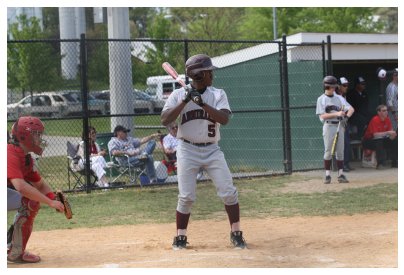

In [ ]:
def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a street with cars and cars on the street


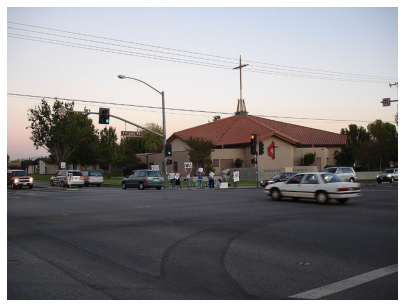

a red fire hydrant sitting next to a fire hydrant


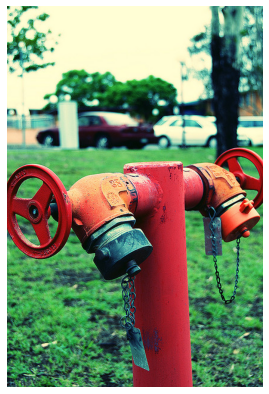

a large semi truck driving down a street


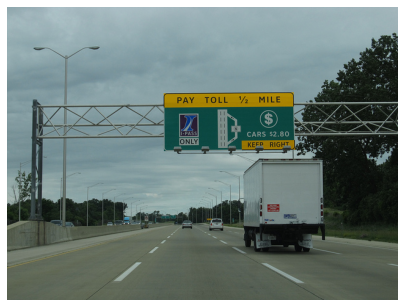

a traffic light suspended over a street with a traffic light


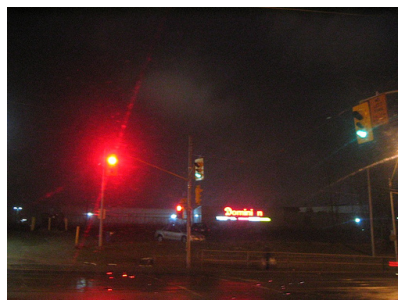

a giraffe standing in the middle of a field


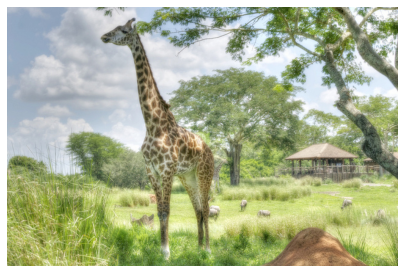

a boat is docked in a harbor with a lighthouse in the background


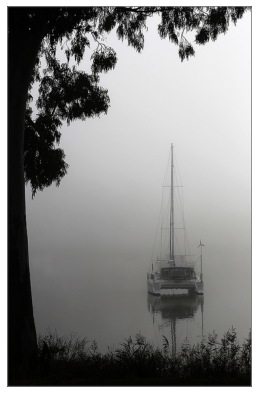

a man in a suit and tie in a room


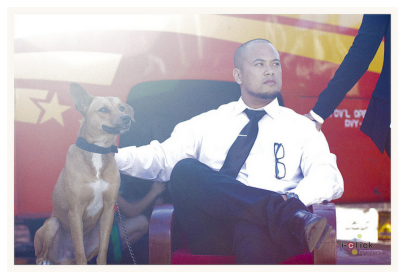

a cat sitting on a chair with a cat on the floor


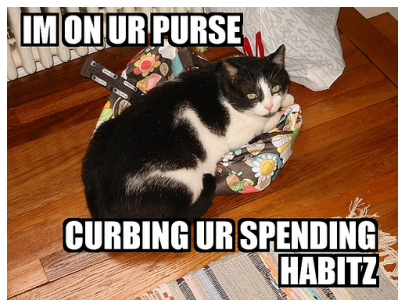

a bus that is driving down a street


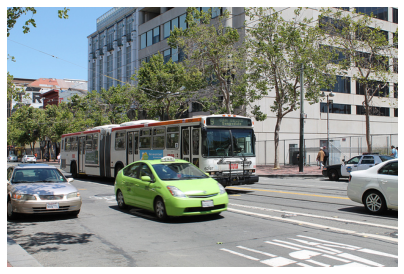

a street sign with a sign on the side of it


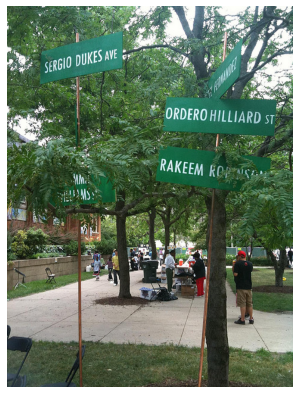

In [ ]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [ ]:
### YOUR EXAMPLES HERE ###
import requests
def get_image_bytes(url):
  resp=requests.get(url)
  resp.raise_for_status()
  return resp.content

def apply_model_to_image_url(url):
  return apply_model_to_image_raw_bytes(get_image_bytes(url))

**Good Example #1**

a group of people standing around a large crowd


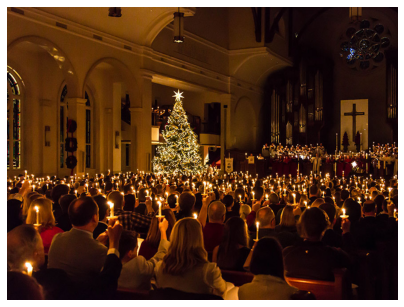

In [ ]:
apply_model_to_image_url('https://www.theahaconnection.com/wp-content/uploads/2017/12/prumc-christmas.jpg')

**Good Example #2**

a table topped with plates of food and bowls of food


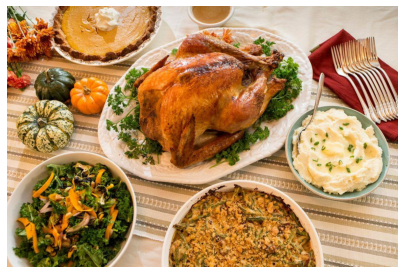

In [ ]:
apply_model_to_image_url('https://www.timesonline.com/storyimage/ZZ/20191122/ENTERTAINMENTLIFE/191129956/AR/0/AR-191129956.jpg')

**Good Example #3**

a clock tower with a clock tower in the middle of it


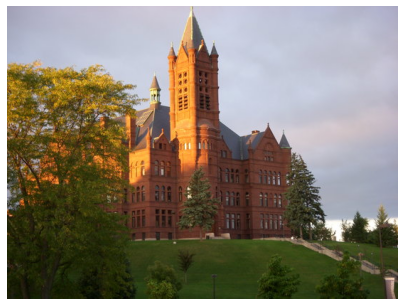

In [ ]:
apply_model_to_image_url('http://media-cdn.tripadvisor.com/media/photo-s/01/06/a4/08/syracuse-university.jpg')

**Bad Example #1**

a man on a skateboard is doing a trick


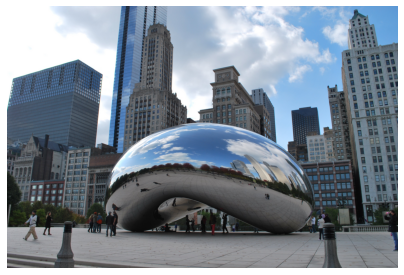

In [ ]:
apply_model_to_image_url('https://www.trbowlin.com/wp-content/uploads/2017/01/DSC_2726.jpg')

**Bad Example #2**

a large building with a clock on the side of it


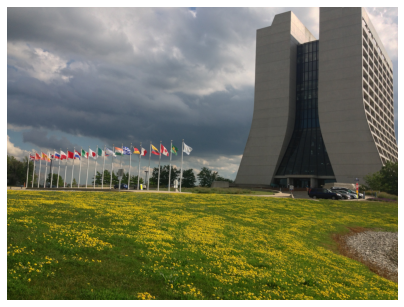

In [ ]:
apply_model_to_image_url('https://www.fnal.gov/pub/today/archive/archive_2015/images/yellow-flowers.jpg')

**Good Example #4**

a herd of cows standing in a field with a dog


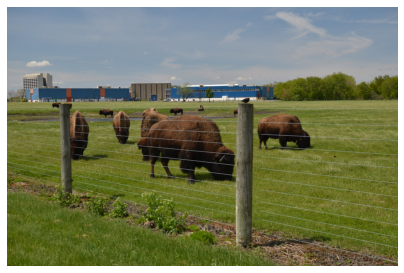

In [ ]:
apply_model_to_image_url('https://live.staticflickr.com/7039/7104238407_dee8ea1863_b.jpg')

**Bad Example #3**

a man riding a wave on a surfboard


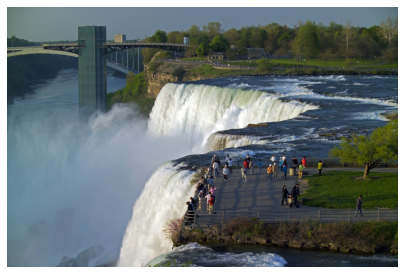

In [ ]:
apply_model_to_image_url('https://res.cloudinary.com/simpleview/image/upload/crm/newyorkstate/Niagara-Falls-State-Park_Niagara-Falls_NY_b3c1c81a-e9d5-8376-1383f8b57041e046.jpg')

**Good Example #5**

a truck with a truck parked on the side of the road


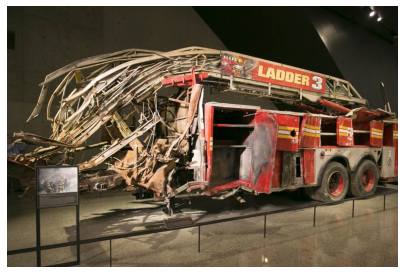

In [ ]:
apply_model_to_image_url('http://media1.s-nbcnews.com/j/newscms/2014_20/442991/ss-140514-9-11-museum-005_eb9bf432ad8f99717b6c8fdf04195d0c.nbcnews-fp-1200-800.jpg')

**Bad Example #4**

a train is coming down a road with a mountain in the background


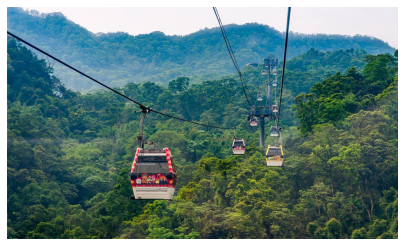

In [ ]:
apply_model_to_image_url('https://www.remotelands.com/travelogues/wp-content/uploads/2018/11/Taiwan-1.jpg')

**Bad Example #5**

a large group of people walking on a beach


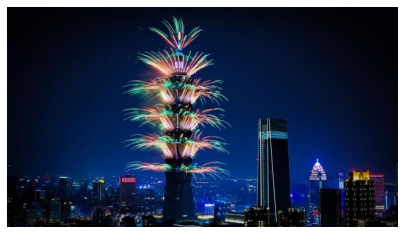

In [ ]:
apply_model_to_image_url('https://www.taiwanembassy.org/uploads/sites/62/2018/01/img20180102172434195.jpg')

**Good Example #6**

a building with a sign on the side of the road


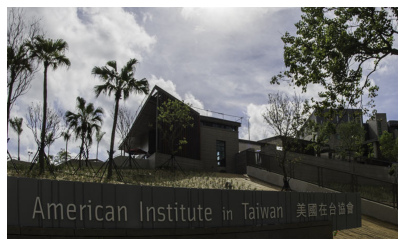

In [ ]:
apply_model_to_image_url('https://d2v9ipibika81v.cloudfront.net/uploads/sites/269/ait-neihu-750x450-1.jpg')

**Good Example #7**

a large mountain goat in a field with a mountain in the background


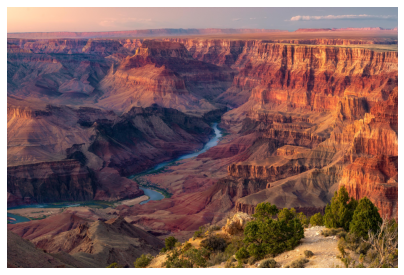

In [ ]:
apply_model_to_image_url('https://peopledotcom.files.wordpress.com/2019/05/grand-canyon-2.jpg')

**Good Example #8**

a baseball player swinging a bat at a ball


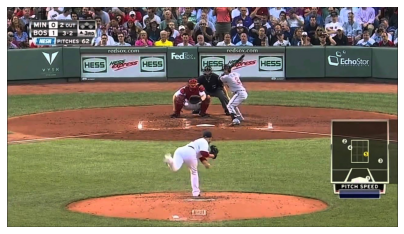

In [ ]:
apply_model_to_image_url('https://i.ytimg.com/vi/iWKwCmD51Fg/maxresdefault.jpg')

**Bad Example #6**

a large bird flying over a tree with a sky background


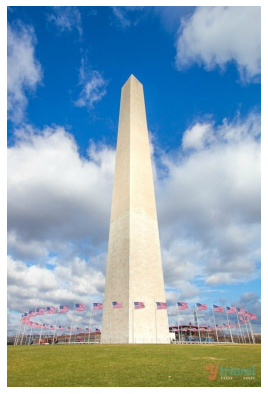

In [ ]:
apply_model_to_image_url('https://www.ytravelblog.com/wp-content/uploads/2014/12/Washington-DC-93.jpg')

**Bad example #7**

a small bird on a rock in the water


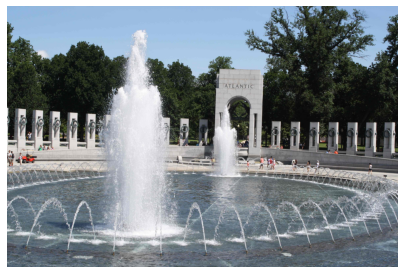

In [ ]:
apply_model_to_image_url('https://www.abackpackjournalist.com/wp-content/uploads/2013/06/WW-2-fountain.jpg')

**Bad Example #8**

a group of people sitting around a table with laptops


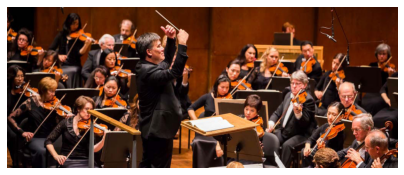

In [ ]:
apply_model_to_image_url('https://broadway.showtickets.com/cdn/site/philarmonic_carousel1_2.jpg')

**Good Example #9**

a sandwich with a pickle and a pickle on a plate


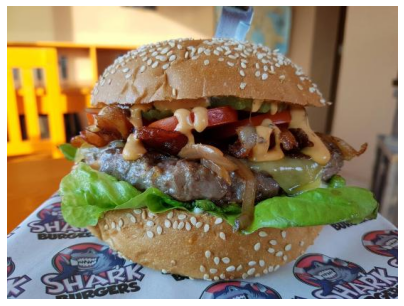

In [ ]:
apply_model_to_image_url('https://media-cdn.tripadvisor.com/media/photo-s/0b/04/8c/2e/shark-burgers.jpg')

**Good Example #10**

a large mountain with a large mountain in the distance


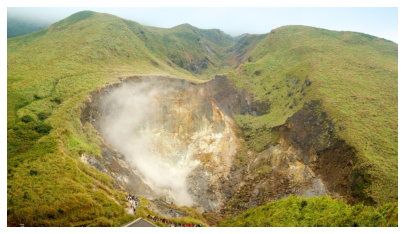

In [ ]:
apply_model_to_image_url('https://a.travel-assets.com/findyours-php/viewfinder/images/res60/56000/56707-Yangmingshan-National-Park.jpg')

**Bad Example #10**

a plate with a piece of cake and a fork


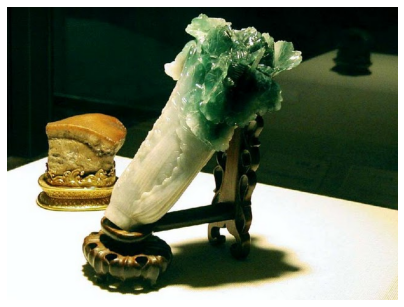

In [ ]:
apply_model_to_image_url('https://kongmu.files.wordpress.com/2011/08/jade-cabbage-pork-stone.jpg')

**Bad Example #10**

a bowl of soup with a spoon in it


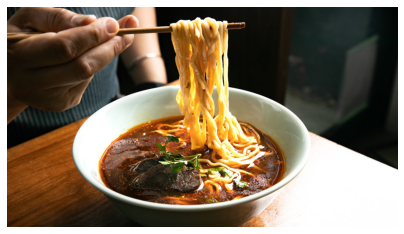

In [ ]:
apply_model_to_image_url('https://static01.nyt.com/images/2019/06/12/dining/11Taiwan1/11Taiwan1-videoSixteenByNineJumbo1600.jpg')

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!